In [1]:
import numpy as np
import h5py
import glob
import os
import sys
import re
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
%matplotlib inline
from os.path import expanduser
from itertools import zip_longest
home = expanduser("~")
host = os.getenv('HOSTNAME')
print(host)

None


In [2]:
if host is not None:
    if 'bebop' in host:
        input_dir = '/lcrc/project/galsampler/Catalog_5000/OR_5000/'
        size_dir = '/lcrc/project/galsampler/Validation_Data/Sizes'
else:
    #input_dir = '/lus/eagle/projects/LastJourney/kovacs/Catalog_5000/OR_5000/'
    #size_dir = '/lus/eagle/projects/LastJourney/kovacs/Validation_Data/Sizes'
    #laptop
    input_dir = '/Users/kovacs/Catalog_5000/OR_5000/roman_rubin_2023_v1.1.3'
    size_dir = '/Users/kovacs/Validation_Data/Sizes'
    notebook_dir = '/Users/kovacs/cosmology/diff_notebooks'
fname = 'roman_rubin_2023_z_*_cutout_{}.hdf5'
from diffaux.validation.get_catalog_data import get_fhlist
from diffaux.validation.get_catalog_data import get_colnames
#from lsstdesc_diffsky.write_mock_to_disk import get_astropy_table
from diffaux.size_modeling import zhang_yang17

In [426]:
validation_info = {'Re_vs_Mstar': {'samples': ['All', 'Star_forming', 'Quiescent'],
                                   'colors': ['black', 'blue', 'red'],
                                   'missing_values': '--',
                                   'filling_values': 0.0,
                                   'read': read_Re_vs_Mstar,
                                   'xlabel': '$\log_{10}(M^*/M_\odot)$',
                                   'ylabel': '$\log_{10}(R_{e}/\mathrm{kpc})$',
                                   'martorano_2024': {
                                       'filename': 'martorano_2024_table1_Mstar_log10Re_{}.txt',
                                       'skip_header': 10,
                                       'dz': .5,
                                       'z_lo': 0.5,
                                       'z_hi': 2.5,
                                       'M*_columns': [0, 1],
                                       'M*_colnames': ['M*_lo', 'M*_hi'],
                                       'data_colnames': ['M*_med', 'log10_Re_16%', 'log10_Re_50%', 'log10_Re_84%'],
                                       'x-values': 'M*_med',
                                       'y-values': 'log10_Re_50%',
                                       'y-error+': 'log10_Re_84%',
                                       'y-error-': 'log10_Re_16%',
                                       'suptitle': 'Martorano et al. 2024 - JWST & COSMOS',
                                       'wavelength': '$1.5\mu m$',
                                                    },
                                  },
                   'Re_vs_z': {
                               'missing_values': '--',
                               'filling_values': 0.0,
                               'read': read_Re_vs_z,
                               'x-values': 'M*med',
                               'y-values': ['alpha_{}','beta_{}'], 
                               'y-errors+': ['dalpha_{}+','dbeta_{}+'],
                               'y-errors-': ['dalpha_{}-','dbeta_{}-'],
                               'xlabels': ['$\log_{10}(M^*/M_\odot)$', '$\log_{10}(M^*/M_\odot)$'],
                               'ylabels': ['$\\alpha_1$', '$\\beta_1$'],
                               'titles': ['$\\alpha_1$: $\log_{10}(R_e) = \\alpha_1 + \\beta_1*\log_{10}(1 + z)$',
                                          '$\\beta_1$: $\log_{10}(R_e) = \\alpha_1 + \\beta_1*\log_{10}(1 + z)$'],
                               'xlabel': '$z$',
                               'ylabel': '$\log10(R_{e}/\mathrm{kpc})$',
                               'martorano_2024': {
                                   'samples': ['All', 'Star-forming', 'Quiescent'],
                                   'colors': ['black', 'blue', 'red'],
                                   'filename': 'martorano_2024_table2_Re_vs_z.txt',
                                   'skip_header': 4,
                                   'M*_colnames': ['M*_lo', 'M*_hi', 'M*med'],
                                   'M*_columns': [0, 1, 2],
                                   'data_colnames': ['alpha_{}', 'dalpha_{}+',  'dalpha_{}-',
                                                     'beta_{}',  'dbeta_{}+', 'dbeta_{}-',
                                                ],
                                   'markers': ['s', 's'],
                                   'wavelength': '$1.5\mu m$',
                                   'short_title': 'JWST, COSMOS',
                                   'suptitle': 'Martorano et. al. 2024 -- JWST, COSMOS',
                                                },
                               'mowla_2018': {
                                         'samples': ['All', 'Star-forming', 'Quiescent'],
                                         'colors': ['black', 'blue', 'red'],
                                         'filename': 'mowla_2018_table1b_Re_vs_z.txt',
                                         'skip_header': 3,
                                         'M*_colnames': ['M*med'],
                                         'M*_columns': [0],
                                         'data_colnames': ['B_{}', 'dB_{}+', 'beta_{}',  'dbeta_{}+'],
                                         'markers': ['o', 'o'],
                                         'convert_to_log': True,
                                         'value_columns': [0],
                                         'error_columns': [1],
                                         'wavelength': '$0.55\mu m$',
                                         'short_title': 'COSMOS-DASH',
                                         'suptitle': 'Mowla et al. 2018 -- COSMOS-DASH',
                                             },
                               'vanderWel_2014': {
                                         'samples': ['Star-forming', 'Quiescent'],
                                         'colors': ['blue', 'red'],
                                         'filename': 'vanderWel_2014_table2_Re_vs_z.txt',
                                         'skip_header': 3,
                                         'M*_colnames': ['M*med'],
                                         'M*_columns': [0],
                                         'data_colnames': ['alpha_{}', 'dalpha_{}+', 'logbeta_{}',  'dlogbeta_{}+'],
                                         'markers': ['^', '^'],
                                         'convert_from_log': True,
                                         'value_columns': [2],
                                         'error_columns': [3],
                                         'wavelength': '$0.5\mu m$',
                                         'short_title': '3D-HST+CANDELS',
                                         'suptitle': 'van der Wel et al. 2014 -- 3D-HST+CANDELS',
                                             },
                              },
            }
def read_size_data(data, authors, validation_info=validation_info, info_key='Re_vs_Mstar', sample='', size_dir=size_dir):
    # setup data dict
    if info_key not in data.keys(): data[info_key] = {}
    v_info = validation_info[info_key]
    for author in authors:
        if author in v_info.keys():
            if author not in data[info_key].keys(): data[info_key][author] = {}
            fn= os.path.join(size_dir, author, v_info[author]['filename'].format(sample))
            print('Reading data from {}'.format(fn))
            tmp = np.genfromtxt(fn, skip_header=v_info[author]['skip_header'],
                                missing_values=v_info['missing_values'],
                                filling_values=v_info['filling_values'],
                               )
            if info_key == 'Re_vs_Mstar':
                data[info_key][author] = v_info['read'](tmp, data[info_key][author], sample, v_info[author])
            elif info_key == 'Re_vs_z':
                data[info_key][author] = v_info['read'](tmp, data[info_key][author], author, v_info)

    return data

def read_Re_vs_Mstar(tmp, data, sample, validation_info):
    #collect M* values if not already in dict
    if not all([cname in data.keys() for cname in validation_info['M*_colnames']]):
        for col, colname in zip(validation_info['M*_columns'], validation_info['M*_colnames']):
            data[colname] = tmp[:, col]

    
    #collect M_med, log10(R_e) values for each z bin
    for n, zlo in enumerate(np.arange(validation_info['z_lo'], validation_info['z_hi'],
                                      validation_info['dz'])):
        zhi = zlo + validation_info['dz']
        #print(n, zlo, zhi)
        zlabel = '${:.1f} \leq z < {:.1f}$'.format(zlo, zhi)
        if zlabel not in data.keys(): data[zlabel] = {}
        if sample not in data[zlabel].keys(): data[zlabel][sample] = {}
        for i, colname  in enumerate(validation_info['data_colnames']):
            col = len(validation_info['M*_columns']) + i + n*len(validation_info['data_colnames'])
            data[zlabel][sample][colname] = tmp[:, col]
    
    return data

def read_Re_vs_z(tmp, data, author, validation_info):

    # collect M* columns 
    v = validation_info[author]
    for col, colname in zip(v['M*_columns'], v['M*_colnames']):
        data[colname] = tmp[:, col]

    for n, sample in enumerate(validation_info[author]['samples']):
        for i, colname in enumerate(v['data_colnames']):
            col = len(v['M*_columns']) + i + n*len(v['data_colnames'])
            colname = colname.format(sample)
            data[colname] = tmp[:, col]

    # Check for non-logarithmic values in data and single-sided error values
    # and complete columns to match other data sets
    for sample in validation_info[author]['samples']:
        for yval, yerr_p, yerr_n in zip(validation_info['y-values'],
                                        validation_info['y-errors+'],
                                        validation_info['y-errors-']):
            yval = yval.format(sample)
            yerr_p = yerr_p.format(sample)
            yerr_n = yerr_n.format(sample)
            if 'convert_to_log' in v.keys() or 'convert_from_log' in v.keys():
                if yval not in data.keys():
                    # convert value columns and error columns to or from log
                    for val_idx, err_idx in zip(v['value_columns'],
                                                v['error_columns']):
                        old_val = v['data_colnames'][val_idx].format(sample)
                        mask = data[old_val] != 0
                        data[yval] = np.zeros(len(data[old_val]))
                        old_err = v['data_colnames'][err_idx].format(sample)
                        data[yerr_p] = np.zeros(len(data[old_val]))
                        if 'convert_to_log' in v.keys() and v['convert_to_log']:
                            data[yval][mask] = np.log10(data[old_val][mask])
                            print('..Converting {} to log'.format(old_val))
                            data[yerr_p][mask] = np.log10(data[old_val][mask]
                                                 + data[old_err][mask]) - data[yval][mask]
                            print('..Converting {} to log'.format(old_err))
                        elif 'convert_from_log' in v.keys() and v['convert_from_log']:
                            data[yval][mask] = np.pow(10, data[old_val][mask])
                            print('..Converting {} from log'.format(old_val))
                            data[yerr_p][mask] = np.pow(10, data[old_val][mask]
                                                        + data[old_err][mask]) - data[yval][mask]
                            print('..Converting {} from log'.format(old_err))
                            # Assume symmetric errors for now
                            #data[yerr_n] = data[yval] - np.log10(data[old_val] - data[old_err])
            if yerr_n not in data.keys():
                data[yerr_n] = data[yerr_p]
                print('..Assigning symmetric errors for {}'.format(yerr_n))
                
        
    return data

In [427]:
authors = ['martorano_2024', 'mowla_2018', 'vanderWel_2014']
#authors = ['vanderWel_2014']
data = {}
#for sample in validation_info['Re_vs_Mstar']['samples']:
#    data= read_size_data(data, authors, info_key='Re_vs_Mstar', sample=sample)
data= read_size_data(data, authors, info_key='Re_vs_z')
#print(data['Re_vs_z'])

Reading data from /Users/kovacs/Validation_Data/Sizes/martorano_2024/martorano_2024_table2_Re_vs_z.txt
Reading data from /Users/kovacs/Validation_Data/Sizes/mowla_2018/mowla_2018_table1b_Re_vs_z.txt
..Converting B_All to log
..Converting dB_All+ to log
..Assigning symmetric errors for dalpha_All-
..Assigning symmetric errors for dbeta_All-
..Converting B_Star-forming to log
..Converting dB_Star-forming+ to log
..Assigning symmetric errors for dalpha_Star-forming-
..Assigning symmetric errors for dbeta_Star-forming-
..Converting B_Quiescent to log
..Converting dB_Quiescent+ to log
..Assigning symmetric errors for dalpha_Quiescent-
..Assigning symmetric errors for dbeta_Quiescent-
Reading data from /Users/kovacs/Validation_Data/Sizes/vanderWel_2014/vanderWel_2014_table2_Re_vs_z.txt
..Assigning symmetric errors for dalpha_Star-forming-
..Converting logbeta_Star-forming from log
..Converting dlogbeta_Star-forming+ from log
..Assigning symmetric errors for dbeta_Star-forming-
..Assigning sy

In [437]:
from diffaux.validation.make_plots import get_nrow_ncol, save_fig, fix_plotid

def plot_Re_vs_Mstar(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
              pltname='log10Re_vs_Mstar_{}.pdf'):

    zkeys = [k for k in data.keys() if 'z' in k]
    nrow, ncol = get_nrow_ncol(len(zkeys))
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, zlabel in zip(ax_all.flat, zkeys):
        for (sample, v), color in zip(data[zlabel].items(), validation_info['colors']):
            xcol = validation_info[author]['x-values']
            ycol = validation_info[author]['y-values']
            mask = v[xcol] > 0.
            if np.count_nonzero(mask) > 0:
                ax.plot(v[xcol][mask], v[ycol][mask], color=color, label=sample)
                ax.fill_between(v[xcol][mask], v[validation_info[author]['y-error-']][mask], 
                                v[validation_info[author]['y-error+']][mask],
                                facecolor=color, alpha=0.2)
        ax.set_xlabel(validation_info['xlabel'])
        ax.set_ylabel(validation_info['ylabel'])
        ax.legend(loc='best')
        ax.set_title(zlabel)
        
    fig.tight_layout()
    fig.suptitle(validation_info[author]['suptitle'], y=1.01)

    pltname = pltname.format(author)
    save_fig(fig, plotdir, pltname)

    return

def plot_Re_vs_z(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
                 pltname='Re_vs_z_{}.pdf', summary_fig=None, summary_ax=None, save_summary=False):

    # fit coefficient plot: log10(Re) = α1 + β1 log10(1 + z)
    nrow, ncol = get_nrow_ncol(len(validation_info['y-values']))
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    if summary_fig is None:
        summary_fig, summary_ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, sumax, yvalue, yerr_p, yerr_m, xlabel, ylabel, marker, title in zip(ax_all.flat,
                                                                        summary_ax.flat,
                                                                        validation_info['y-values'],
                                                                        validation_info['y-errors+'],
                                                                        validation_info['y-errors-'],
                                                                        validation_info['xlabels'],
                                                                        validation_info['ylabels'],
                                                                        validation_info[author]['markers'],
                                                                        validation_info['titles'],
                                                         ):
        for sample, color in zip(validation_info[author]['samples'],validation_info[author]['colors']):
            xcol = validation_info['x-values']
            ycol = yvalue.format(sample)
            lower_error = np.abs(data[yerr_p.format(sample)])
            upper_error = np.abs(data[yerr_m.format(sample)])
            #mask for missing values
            mask = np.abs(data[ycol]) > 0.
            #print(asymmetric_error)
            if np.count_nonzero(mask) > 0:
                asymmetric_error = [lower_error[mask], upper_error[mask]]
                ax.errorbar(data[xcol][mask], data[ycol][mask], yerr=asymmetric_error, label=sample, color=color,
                            marker=marker, linestyle='')
                sum_label = '{} ({}) {}'.format(sample, validation_info[author]['short_title'],
                                                validation_info[author]['wavelength'])
                sumax.errorbar(data[xcol][mask], data[ycol][mask], yerr=asymmetric_error, label=sum_label, color=color,
                            marker=marker, linestyle='')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend(loc='best')

        if save_summary:
            sumax.set_xlabel(xlabel)
            sumax.set_ylabel(ylabel)
            sumax.set_title('{}'.format(title))
            sumax.legend(loc='best', ncols=2, fontsize='x-small')
                                           
    if 'M*_lo' in validation_info[author]['M*_colnames'] and 'M*_hi' in validation_info[author]['M*_colnames']:
        idx_lo = validation_info[author]['M*_colnames'].index('M*_lo')
        idx_hi = validation_info[author]['M*_colnames'].index('M*_hi')
        for Mlo, Mhi in zip(data[validation_info[author]['M*_colnames'][idx_lo]],
                        data[validation_info[author]['M*_colnames'][idx_hi]]):
            Mlabel = '${:.1f} \leq \log10(M^*/M_\odot) < {:.1f}$'.format(Mlo, Mhi)


    #fig.tight_layout()
    fig.suptitle('{} ({})'.format(validation_info[author]['suptitle'],
                                  validation_info[author]['wavelength']), y=1.01)

    save_fig(fig, plotdir, pltname.format(author))
    if save_summary:
        save_fig(summary_fig, plotdir, pltname.format('summary'))
        
    
    return summary_fig, summary_ax

Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_martorano_2024.pdf
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_mowla_2018.pdf
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_vanderWel_2014.pdf
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_summary.pdf


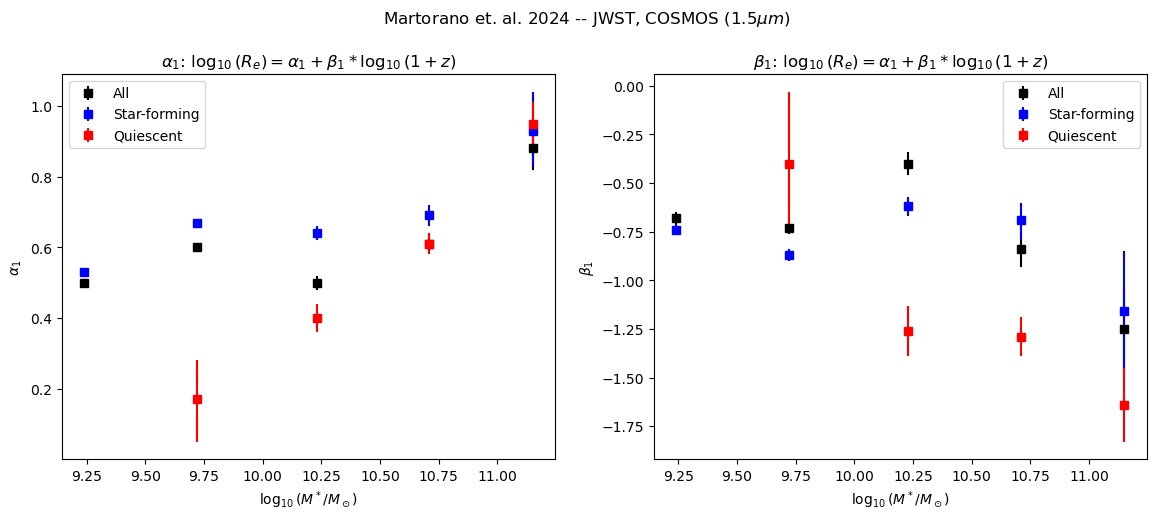

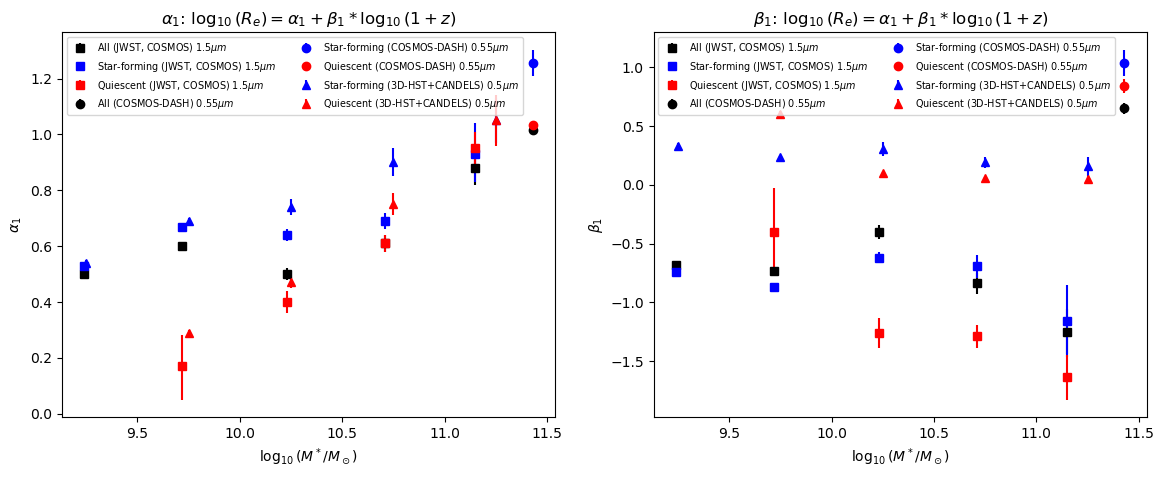

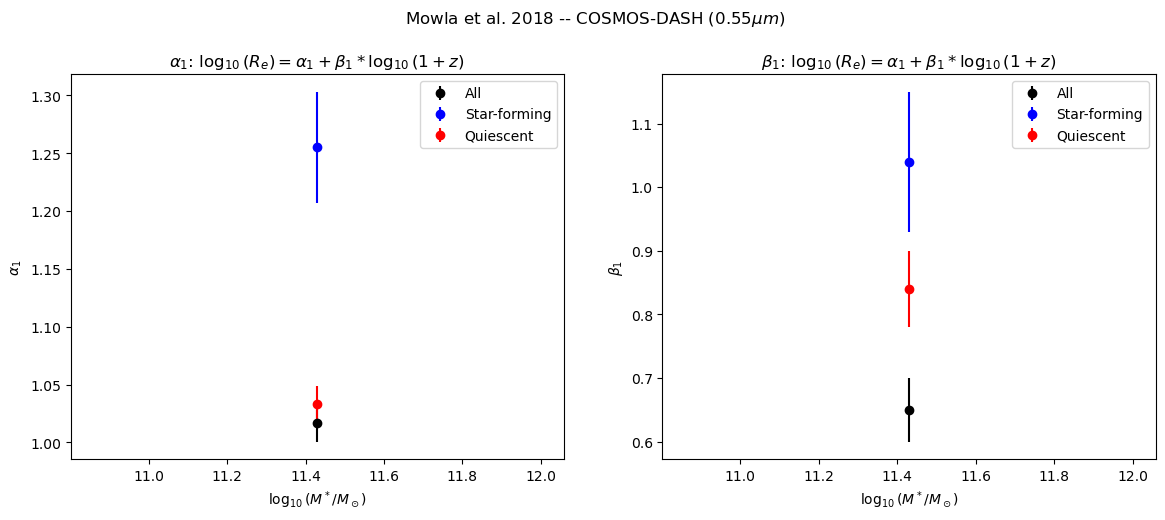

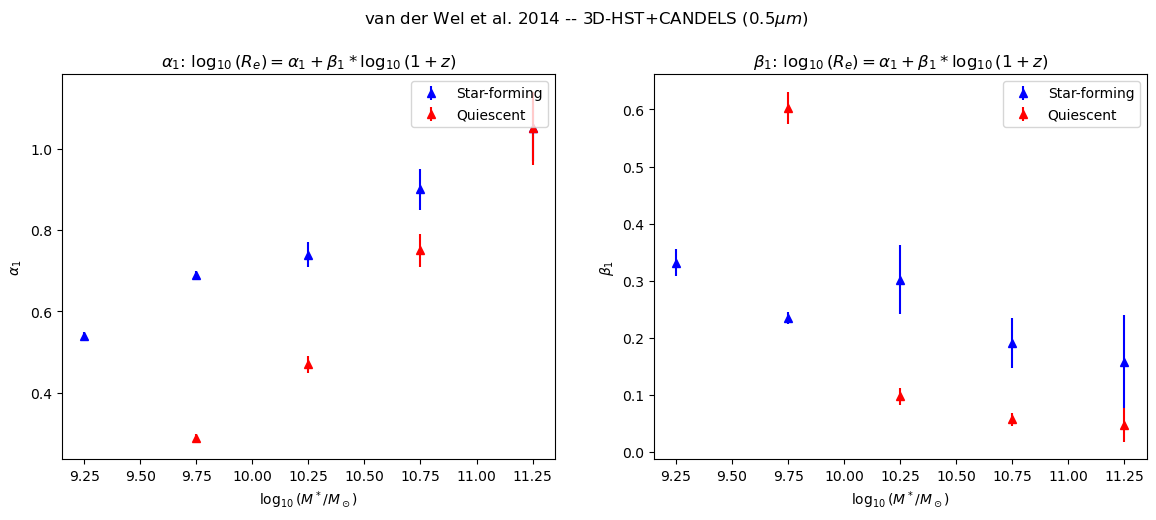

In [438]:
#log10(Re) = α1 + β1*log10(1 + z)
sum_fig = None
sum_ax = None
for author in authors:
    if 'Re_vs_Mstar' in data.keys() and author in data['Re_vs_Mstar'].keys():
        plot_Re_vs_Mstar(data['Re_vs_Mstar'][author], author, validation_info['Re_vs_Mstar'])
    if 'Re_vs_z' in data.keys() and author in data['Re_vs_z'].keys():
        save_summary = (author == authors[-1])
        sum_fig, sum_ax = plot_Re_vs_z(data['Re_vs_z'][author], author, validation_info['Re_vs_z'],
                                       summary_fig=sum_fig, summary_ax=sum_ax, save_summary=save_summary)